# Quick start

## Installation

The Python module can be directly installed from [PyPI](https://pypi.org/project/anta-database/) with:

    pip install anta_database


This Python module is designed to query and visualized data in a AntADatabase folder. The latter has to be first compiled using published IRH datasets, or you can contact for downloading it.
You can already have a look at this guide to have an idea of the features of this tool. This Jupyter Notebook can be directly downloaded (top bar) and ran locally (assuming you had downloaded or compiled the AntADatabase folder).


## Browsing the database

First, initialize the Database class by providing the full path to the AntADatabase:

In [10]:
from anta_database import Database

db = Database('/home/anthe/documents/data/isochrones/AntADatabase/')

Use the query() function to browse the database. 'query()' without argument will return all metadata contained in the database:

In [11]:
db.query()

Metadata from query:

  - dataset: Siegert_2004, Ashmore_2020, Bodart_2021, Beem_2021, Muldoon_2023, Bodart_2025a, Franke_2025, Bodart_2025b, Yan_2025, Cavitte_2020, Mulvaney_2023, Jacobel_2005, Leysinger_Vieli_2011, Wang_2023, Winter_2018, Sanderson_2024, Chung_2023

  - institute: AWI, AWI, LDEO, BAS, BAS, AWI, NASA-CRESIS, UTIG-AAD, BAS, NASA-CRESIS, UTIG-AAD, NASA-CRESIS, PRIC-UTIG-AAD, SPRI-NSF-DTU, St-Olaf-College, UTIG, UTIG, PRIC, UTIG, UA

  - project: AGAP-NORTH, POLARGAP, ANTR, ANTR, AGAP-SOUTH-GAMBIT, BBAS, BE-OI, CHARISO, ANTR, SNACC-DML, ICECAP2, IMAFI, OIB, OIB, ANTR, WISE_ISODYN, ICECAP, OIB, ICECAP-OIA, BE-OI, SOAR-CASERTZ, SOAR-DVD, ATRS, AGASEA, GIMBLE, SPC, PPT, US-ITASE, nan

  - acquisition_year: 1970-1979, 1974-1978, 1998-2008, 1999-2025, 2001-2002, 2004, 2005, 2005-2019, 2007-2016, 2009, 2010, 2011, 2012, 2013, 2016, 2016-2018, 2016-2019, 2017, 2018, None

  - age: 800, 2615, 3100, 4700, 4720, 4800, 5600, 6400, 6500, 6940, 7200, 7400, 8500, 9500, 10000, 10516, 1

The query() function takes as argument:
- dataset: dataset(s) of interest
- institute: institutes(s) that produced the data
- project: project(s) under which the data were collected
- acquisition_year: year(s) in which the radar data were acquired
- age: age(s) in yrs before present of the layer(s) of interest
- region: region(s) of interest. E.g.: 'EAIS', 'WAIS'
- basin: IMBIE basin(s) of interest. E.g.: 'G-H', 'Ap-B'
- var: variables(s) of interest. Possible variables currently are: 'IRH_DEPTH', 'IRH_DENS', 'ICE_THCK', 'BED_ELEV', 'SURF_ELEV'
- flight_id: ID of a particular flight line. This is useful for explicit flight IDs such as 'DC_LDC_DIVIDE'

One can also combine field queries as well as providing lists. Use '%' for searching by regular expressions. Here are a few examples:

In [12]:
#Examples of queries:
db.query(dataset='Cavitte_2020') # all data from Cavitte et al. 2020
db.query(age='38100') # all datasets with the 38.1ka isochrone
db.query(var='ICE_THK') # all datasets with IceThk variable
db.query(IMBIE_basin='G-H') # all flight lines that cross the G-H basin
db.query(flight_id='DC_LDC_DIVIDE') # all layers with the flight ID DC_LDC_DIVIDE
db.query(flight_id='%WSB%') # all flight lines with WSB in the flight ID
db.query(dataset=['Franke_2025', 'Winter_2018'], age='38100') # example of multiple criteria

Metadata from query:

  - dataset: Franke_2025, Winter_2018

  - institute: AWI

  - project: ANTR

  - acquisition_year: 1998-2008, None

  - age: 38100

  - age_unc: 100

  - var: BED_ELEV, ICE_THK, IRH_DEPTH, IRH_NUM, SURF_ELEV

  - region: EAIS

  - IMBIE_basin: A-Ap, B-C, Jpp-K, K-A

  - radar_instrument: AWI-UWB, EMR, EMR

  - flight_id: 20023154, 20231211_01_015, 20231211_02_013, 19993105, 20173004, 20181227_03_002, 20173003, 19972313, 20231203_04_006, 19972304, 20231211_02_007, 19993134, EPICA_II_04, 20181226_01_010, 20181226_01_008, 20231129_01_009, 20023149, 19993115, 20231211_02_001, 19993137, 20181227_02_006, 20181226_02_009, 20013012, 19983404, 19993135, [ ... ] , 20181227_03_007, 20033141, 19983401, 20022107, 20181227_02_001, 20181227_03_003, 19972404, 20231211_01_016, 19972402, 20181226_01_007, 19983206, 20231129_01_012, 19983204, 20023115, 19983202, 19972415, 20181222_01_004, 19993132, 19972406, 20231211_01_008, 19972309, 20231211_02_005, 20231129_01_011, 20023109, EPIC

The filter_out() function allows the pre-filter out some data so they would never be included in the next queries. 

In [13]:
%%capture
db.filter_out(acquisition_year='<1990')  # filter out all data acquired before 1990
db.query() # now all queries will exclude data acquired before 1990

db.filter_out()  # reset all filters to include all data again
db.query()

## Visualization

Use the results of the query in the plotting functions:

Plotting: 100%|██████████| 6/6 [00:02<00:00,  2.10dataset/s]


Formatting ...


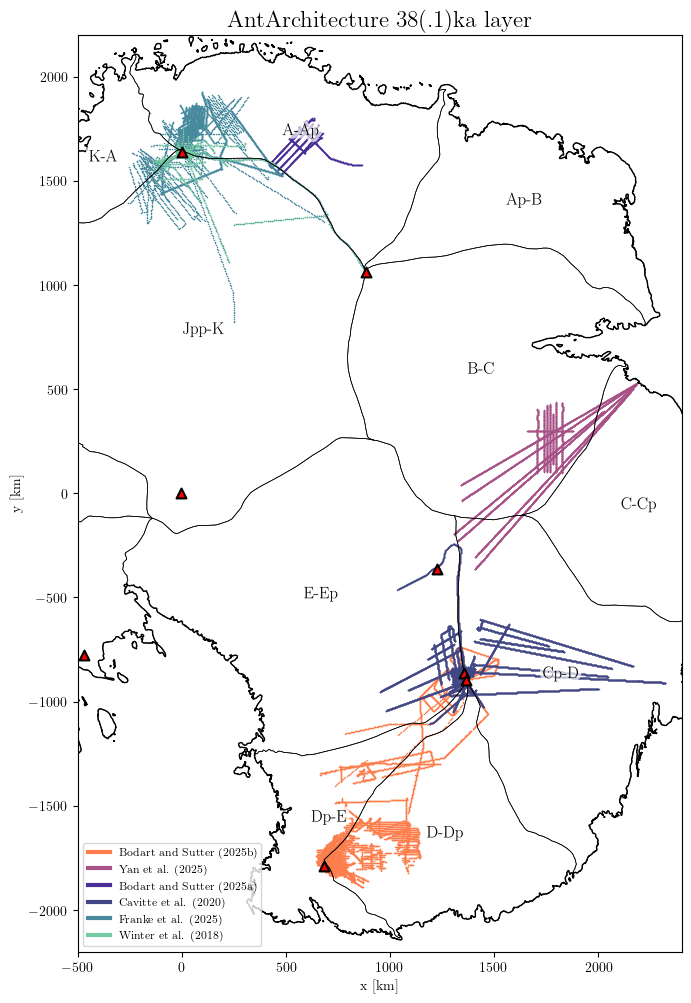

In [14]:
results = db.query(age=['38100','38000'])
db.plot.dataset(results,
                downscale_factor=100, # downscale the datasets n times, which makes no visual difference but it is much lighter
                title='AntArchitecture 38(.1)ka layer',
                xlim=(-500, 2400), ylim=(-2200, 2200), # set the plot extent in km
                scale_factor=0.7, # adjust the size of the plot
                marker_size=1.2, # adjust the size of the markers
                latex=True, # use latex compilers for plotting if you have them installed on your system
                # save='AntA_38ka.pdf', # Uncomment to save the figure, otherwise it we visualize with pyplot
                )

Current implemented plotting functions are:
- plot.dataset(): plots locations of the data, with different colors for the different datasets (example above)
- plot.institute(): plots locations of the data, with different colors for the different institutes
- plot.var(): color-coded scatter plot of the variable of insterest.
- plot.flight_id(): color-coded trace IDs. Useful for identifying specific traces of interest.
- plot.transect(): plots depths of the IRH and Bed along a single flight line 

In Jupyter Notebook, use '%matplotlib qt' or '%matplotlib widget' depending on your IDE, to switch to the matplotlib widget that allows you to zoom in etc.
Use '%matplotlib inline' (default) to plot the figure in the notebook

Plotting: 100%|██████████| 391/391 [00:18<00:00, 20.82trace/s]


Select a unique age for better results
Formatting ...


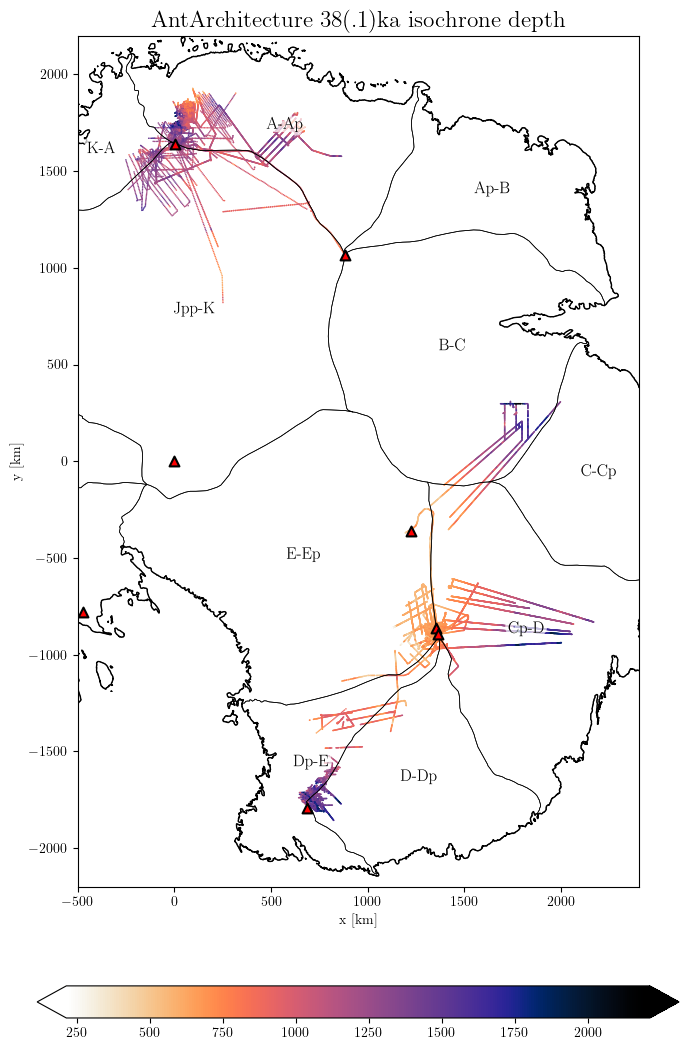

In [15]:
# %matplotlib widget
%matplotlib inline
results = db.query(age=['38100','38000'], var='IRH_DEPTH')
db.plot.var(results, title='AntArchitecture 38(.1)ka isochrone depth',
                downscale_factor=100,
                xlim=(-500, 2400),
                ylim=(-2200, 2200),
                scale_factor=0.7,
                marker_size=1.2,
                latex=True,
                # save='AntA_38ka_depth.png'
                )

In [ ]:
results = db.query(var='IRH_NUM')
db.plot.var(results, title='IRH Density over the Antarctic Ice Sheet',
                downscale_factor=100,
                scale_factor=1,
                marker_size=1.2,
                latex=True,
                )

Plotting:  67%|██████▋   | 596/891 [00:29<00:12, 23.08trace/s]

In [ ]:
results = db.query(dataset='Winter%', flight_id=['EPICA%'])
db.plot.flight_id(results, title='Winter et al. 2018 - EPICA',
                xlim=(-500, 1000),
                ylim=(1000, 2200),
                marker_size=1.2,
                latex=True,
                )

In [ ]:
results = db.query(dataset='Cavitte_2020', flight_id='DC_LDC_DIVIDE')
db.plot.transect(results)

Other possible arguments for the plot methods:
- cmap: provide your colormap of choice (as LinearSegmentedColormap). Tip: 'import colormaps as cmaps' for a large choice of colormaps (see [Colormaps docs](https://pratiman-91.github.io/colormaps/)

## Generate data from the database

Note: This part could be developed further in the future if there is the need. But for now, I am designing a separate Python module for constraining my ice sheet model of use, which is tailored to this database and other parallel processing libraries.

The data_generator() function reads the query and 'yield' the dataframes for later use.
Here is a quick example of how this can be used for computing the mean layer depth:

In [ ]:
results = db.query(age=['38100'], var='IRH_DEPTH')
lazy_dfs = db.data_generator(results)

import numpy as np
mean_depth_trs = []
min_depth = float('inf')
max_depth = float('-inf')
for df, md in lazy_dfs:
    depth_values = df[38100]
    mean_depth_trs.append(np.mean(depth_values))
    min_depth = min(min_depth, min(depth_values))
    max_depth = max(max_depth, max(depth_values))


mean_depth = np.mean(mean_depth_trs)
std_dev = np.std(mean_depth_trs, ddof=1)
print(f"The mean depth of the 38ka isochrone across East Antarctica is {round(mean_depth, 2)} m ranging from {round(min_depth, 2)} m to {round(max_depth, 2)} m.")

In the for loop, 'df' is an individual dataframe from the database, corresponding to a single layer of a single trace from a single dataset. The 'md' stores the unique metadata from the current 'df'. One can then associate the metadata with the current df, for example:

### Downscale the data

The downscale_factor argument in the data_generator reduces the size of the generated data by n times. This is useful when dealing with large data where the downscaling has a neglectable influence on the results.
Another solution, probably more straightforward, is the downsample_distance option, which allows to provide a distance in meters by which the data should be average along the transects:

In [ ]:
import matplotlib.pyplot as plt

results = db.query(dataset='Cavitte_2020', age='277900', flight_id='DC_LDC_DIVIDE')
original = db.data_generator(results)
downscale_10 = db.data_generator(results, downscale_factor=100)
# downsampled_by_distance = db.data_generator(results, downsample_distance=5000)

list = [original, downscale_10] #, downsampled_by_distance]
labels = ['original', 'downscale 100'] #, 'downsample 5km']

for i, lazy_dfs in enumerate(list):
    for df, md in lazy_dfs:
        plt.plot(df.Distance, df[277900],label=labels[i], linestyle='--')

plt.ylim(2600, 1800)
plt.xlabel('Distance along DC_LDC_DIVIDE (km)')
plt.ylabel('Depth (m)')
plt.legend()
plt.title('Different downscaling methods for Cavitte 2020 278ka along DC_LDC_DIVIDE')
plt.show()

# Pro tips

The Database methods always keep the last query in memory. This means that one does not have to actually pass argument.
Example:

In [ ]:
db.query(var='IRH_NUM')
# db.plot.var() # This is equivalent to the overview plot above. Note that without downscaling it is very heavy to plot.

import numpy as np
mean_density_trs = []
min_density = float('inf')
max_density = float('-inf')
for df, md in db.data_generator():    # without explicitly passing results, it uses the last query.
    density_values = df['IRH_NUM']
    mean_density_trs.append(np.mean(density_values))
    min_density = min(min_density, min(density_values))
    max_density = max(max_density, max(density_values))

mean_density = np.mean(mean_density_trs)
print(f"The average number of picked layers per data point in the AntADatabase is {int(mean_density)}, ranging from {int(min_density)} to {int(max_density)}. ")